In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, tensorflow as tf
import sys, time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, MaxPooling1D, GlobalAveragePooling1D, Conv1DTranspose, LSTM, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

2024-03-25 15:37:23.846113: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-25 15:37:23.846254: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-25 15:37:23.995479: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-25 15:37:24.457356: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-25 15:37:30.095013: W tensorflow/compiler/tf2

In [2]:
from tensorflow.keras import backend as K

def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

In [3]:
base_data_train, base_data_test = np.load('../../data/training_data/training_data_1month.npy', allow_pickle=True)
vae_data_train = np.load('../../data/vae_synthetic_data/th_v_air_generated_samples.npy')
vae_data_train_rescaled = np.load('../../data/vae_synthetic_data/th_v_air_rescaled_samples.npy')
base_data_train, base_data_test, vae_data_train = base_data_train[:,:,[0,3]], base_data_test[:,:,[0,3]], vae_data_train[:,:,[0,1]]
print(base_data_train.shape,vae_data_train.shape)

(108, 730, 2) (1000, 730, 2)


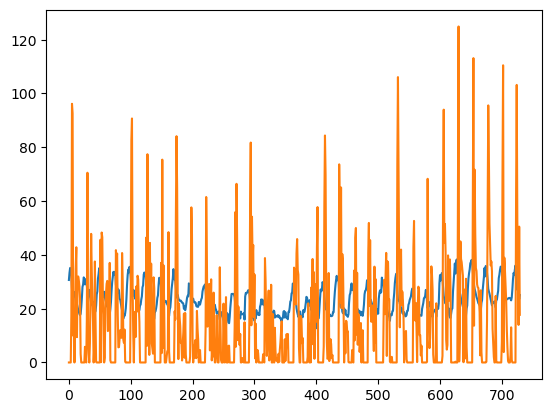

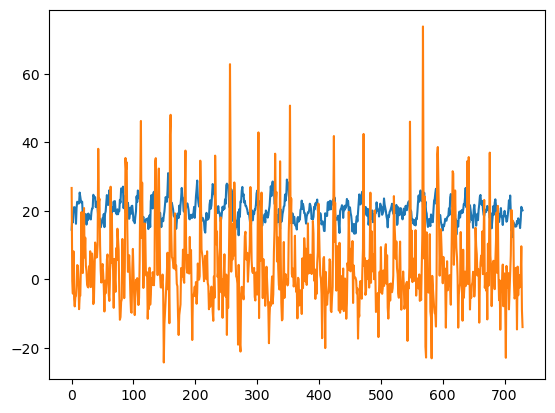

In [4]:
plt.plot(base_data_train[100])
plt.show()
plt.plot(vae_data_train_rescaled[200])
plt.show()

In [5]:
'''def create_cnn(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(input_shape)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(730, activation='linear') #Dense(1)
    ])
    return model

def create_cnn(input_length):
    model = Sequential([
        Conv1D(filters=64, kernel_size=7, activation='relu', input_shape=(input_length, 1)),
        Dropout(0.5),
        LSTM(32, return_sequences=True),
        GlobalAveragePooling1D(),
        Dense(50, activation='relu'),
        Dense(730, activation='linear')  # Output layer for regression
    ])
    return model'''

"def create_cnn(input_shape):\n    model = Sequential([\n        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(input_shape)),\n        MaxPooling1D(pool_size=2),\n        Flatten(),\n        Dense(50, activation='relu'),\n        Dense(730, activation='linear') #Dense(1)\n    ])\n    return model\n\ndef create_cnn(input_length):\n    model = Sequential([\n        Conv1D(filters=64, kernel_size=7, activation='relu', input_shape=(input_length, 1)),\n        Dropout(0.5),\n        LSTM(32, return_sequences=True),\n        GlobalAveragePooling1D(),\n        Dense(50, activation='relu'),\n        Dense(730, activation='linear')  # Output layer for regression\n    ])\n    return model"

In [6]:
def create_cnn(input_shape):
    model = Sequential([
        Conv1D(filters=32, kernel_size=24, activation='relu', input_shape=(input_shape)),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),
        Conv1D(filters=64, kernel_size=24, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(730, activation='linear')
    ])
    return model

In [7]:
print(base_data_train[:,:,0].shape)

(108, 730)


In [8]:
def test_cnn(training_data):
    X_train = training_data[:,:,0].reshape(-1,730,1)
    y_train = training_data[:,:,1]

    X_test = scaled_data_test[:,:,0].reshape(-1, 730, 1)  
    y_test = scaled_data_test[:,:,1]

    X_train, X_train_val, y_train, y_train_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)
                                                                  
    model = create_cnn((X_train.shape[1], X_train.shape[2]))
    model.compile(optimizer=Adam(), loss='mse', metrics=['mse', 'mae', 'accuracy'])

    early_stopping = EarlyStopping(monitor='mse', patience=10, verbose=1, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='mse', factor=0.5, patience=5, verbose=1)
    model.fit(X_train, y_train, epochs=100, batch_size=16, callbacks=[early_stopping, reduce_lr], verbose=1, validation_data=(X_train_val, y_train_val))

    loss, mse, mae, accuracy = model.evaluate(X_test, y_test)
    r2 = r_squared(tf.convert_to_tensor(y_test, dtype=tf.float32), tf.convert_to_tensor(model.predict(X_test), dtype=tf.float32))
    
    return {'mse':mse, 'mae':mae, 'r2':r2.numpy(), 'acc':accuracy}


<h3> Scaling data before evaluation </h3>

Scale base dataset and use the scaled vae dataset

In [9]:
from sklearn.preprocessing import MinMaxScaler

scalers = {var_name: MinMaxScaler(feature_range=(-1,1)) for var_name in ['G.air.T', 'G.E_th_I']}

temp_var, energy_var = base_data_train[:,:,0], base_data_train[:,:,1]
temp_var_test, energy_var_test = base_data_test[:,:,0], base_data_test[:,:,1]

temp_var, temp_var_test = scalers['G.air.T'].fit_transform(temp_var), scalers['G.air.T'].fit_transform(temp_var_test)
energy_var, energy_var_test = scalers['G.E_th_I'].fit_transform(energy_var), scalers['G.E_th_I'].fit_transform(energy_var_test)

scaled_data_train, scaled_data_test = np.stack((temp_var, energy_var), axis=-1), np.stack((temp_var_test, energy_var_test), axis=-1)
print(scaled_data_train.shape, scaled_data_test.shape)

(108, 730, 2) (12, 730, 2)


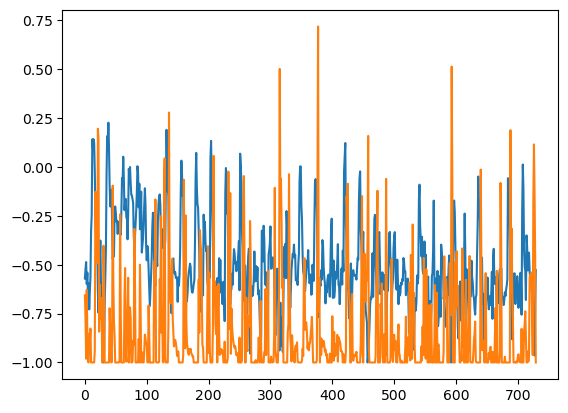

In [10]:
plt.plot(scaled_data_train[10])

Clip energy consumption at 0 and rescale

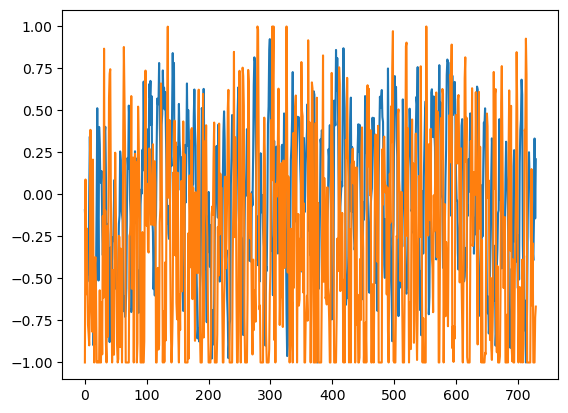

In [11]:
clipped_vae_train = np.clip(vae_data_train_rescaled, a_min=0, a_max=None)
clipped_temp, clipped_energy = clipped_vae_train[:,:,0], clipped_vae_train[:,:,1]
clipped_temp, clipped_energy = scalers['G.air.T'].fit_transform(clipped_temp), scalers['G.E_th_I'].fit_transform(clipped_energy) 

clipped_vae_train = np.stack((clipped_temp, clipped_energy), axis=-1)
plt.plot(clipped_vae_train[50])

In [12]:
import tensorflow as tf

# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

<h3> Use CNN to assess ground truth data </h3>

In [13]:
gt_test = test_cnn(scaled_data_train)
print(gt_test['mse'], gt_test['mae'], gt_test['r2'], gt_test['acc'])

Epoch 1/100


2024-03-25 15:38:09.000124: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fdbe031d730 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-03-25 15:38:09.000173: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-03-25 15:38:09.267923: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


4/6 [===================>..........] - ETA: 0s - loss: 0.6617 - mse: 0.6617 - mae: 0.7492 - accuracy: 0.0000e+00 

I0000 00:00:1711381090.192321  332790 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-03-25 15:38:10.193611: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-25 15:38:10.193717: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-25 15:38:10.195821: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


6/6 [==============================] - 3s 73ms/step - loss: 0.6438 - mse: 0.6438 - mae: 0.7336 - accuracy: 0.0000e+00 - val_loss: 0.5812 - val_mse: 0.5812 - val_mae: 0.6696 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 22ms/step - loss: 0.4876 - mse: 0.4876 - mae: 0.5918 - accuracy: 0.0116 - val_loss: 0.3913 - val_mse: 0.3913 - val_mae: 0.5367 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 21ms/step - loss: 0.3434 - mse: 0.3434 - mae: 0.4850 - accuracy: 0.0116 - val_loss: 0.2619 - val_mse: 0.2619 - val_mae: 0.3841 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 4/100
4/6 [===================>..........] - ETA: 0s - loss: 0.2544 - mse: 0.2544 - mae: 0.3893 - accuracy: 0.0156    

2024-03-25 15:38:10.716431: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


6/6 [==============================] - 0s 21ms/step - loss: 0.2482 - mse: 0.2482 - mae: 0.3874 - accuracy: 0.0116 - val_loss: 0.2094 - val_mse: 0.2094 - val_mae: 0.3512 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 5/100
6/6 [==============================] - 0s 21ms/step - loss: 0.2067 - mse: 0.2067 - mae: 0.3343 - accuracy: 0.0116 - val_loss: 0.1940 - val_mse: 0.1940 - val_mae: 0.3641 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 6/100
6/6 [==============================] - 0s 21ms/step - loss: 0.1883 - mse: 0.1883 - mae: 0.3173 - accuracy: 0.0116 - val_loss: 0.1814 - val_mse: 0.1814 - val_mae: 0.3465 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 7/100
6/6 [==============================] - 0s 21ms/step - loss: 0.1788 - mse: 0.1788 - mae: 0.3153 - accuracy: 0.0116 - val_loss: 0.1729 - val_mse: 0.1729 - val_mae: 0.3190 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 8/100
6/6 [==============================] - 0s 21ms/step - loss: 0.1738 - mse: 0.1738 - mae: 0.3061 - accuracy: 0.0116 - val_loss: 0.1697

Epoch 41/100
6/6 [==============================] - 0s 21ms/step - loss: 0.1195 - mse: 0.1195 - mae: 0.2410 - accuracy: 0.0233 - val_loss: 0.1341 - val_mse: 0.1341 - val_mae: 0.2842 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 42/100
6/6 [==============================] - 0s 21ms/step - loss: 0.1188 - mse: 0.1188 - mae: 0.2399 - accuracy: 0.0233 - val_loss: 0.1423 - val_mse: 0.1423 - val_mae: 0.2994 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 43/100
6/6 [==============================] - 0s 21ms/step - loss: 0.1182 - mse: 0.1182 - mae: 0.2410 - accuracy: 0.0116 - val_loss: 0.1322 - val_mse: 0.1322 - val_mae: 0.2795 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 44/100
6/6 [==============================] - 0s 21ms/step - loss: 0.1175 - mse: 0.1175 - mae: 0.2381 - accuracy: 0.0349 - val_loss: 0.1412 - val_mse: 0.1412 - val_mae: 0.2994 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 45/100
6/6 [==============================] - 0s 22ms/step - loss: 0.1168 - mse: 0.1168 - mae: 0.2401 - accuracy: 0.0349 -

6/6 [==============================] - 0s 21ms/step - loss: 0.1041 - mse: 0.1041 - mae: 0.2253 - accuracy: 0.0465 - val_loss: 0.1238 - val_mse: 0.1238 - val_mae: 0.2475 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 79/100
6/6 [==============================] - 0s 22ms/step - loss: 0.1041 - mse: 0.1041 - mae: 0.2258 - accuracy: 0.0465 - val_loss: 0.1216 - val_mse: 0.1216 - val_mae: 0.2464 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 80/100
6/6 [==============================] - 0s 21ms/step - loss: 0.1039 - mse: 0.1039 - mae: 0.2247 - accuracy: 0.0465 - val_loss: 0.1239 - val_mse: 0.1239 - val_mae: 0.2563 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 81/100
6/6 [==============================] - 0s 22ms/step - loss: 0.1025 - mse: 0.1025 - mae: 0.2228 - accuracy: 0.0233 - val_loss: 0.1273 - val_mse: 0.1273 - val_mae: 0.2685 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 82/100
6/6 [==============================] - 0s 21ms/step - loss: 0.1025 - mse: 0.1025 - mae: 0.2233 - accuracy: 0.046

<h3> Use CNN to assess synthetic data</h3>

Clipped VAE data

In [14]:
clipped_synth_test = test_cnn(clipped_vae_train[0:216,:,:])
print(clipped_synth_test['mse'], clipped_synth_test['mae'], clipped_synth_test['r2'], clipped_synth_test['acc'])

Epoch 1/100
11/11 [==============================] - 1s 35ms/step - loss: 0.4260 - mse: 0.4260 - mae: 0.5585 - accuracy: 0.0000e+00 - val_loss: 0.2739 - val_mse: 0.2739 - val_mae: 0.4434 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
11/11 [==============================] - 0s 20ms/step - loss: 0.2080 - mse: 0.2080 - mae: 0.3630 - accuracy: 0.0058 - val_loss: 0.1671 - val_mse: 0.1671 - val_mae: 0.3363 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
11/11 [==============================] - 0s 20ms/step - loss: 0.1492 - mse: 0.1492 - mae: 0.3029 - accuracy: 0.0058 - val_loss: 0.1482 - val_mse: 0.1482 - val_mae: 0.3133 - val_accuracy: 0.0227 - lr: 0.0010
Epoch 4/100
11/11 [==============================] - 0s 20ms/step - loss: 0.1367 - mse: 0.1367 - mae: 0.2876 - accuracy: 0.0233 - val_loss: 0.1401 - val_mse: 0.1401 - val_mae: 0.3074 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/100
11/11 [==============================] - 0s 20ms/step - loss: 0.1278 - mse: 0.1278 - mae: 0.2732

11/11 [==============================] - 0s 21ms/step - loss: 0.0504 - mse: 0.0504 - mae: 0.1690 - accuracy: 0.0988 - val_loss: 0.0697 - val_mse: 0.0697 - val_mae: 0.2081 - val_accuracy: 0.1364 - lr: 0.0010
Epoch 39/100
11/11 [==============================] - 0s 22ms/step - loss: 0.0487 - mse: 0.0487 - mae: 0.1659 - accuracy: 0.1279 - val_loss: 0.0747 - val_mse: 0.0747 - val_mae: 0.2183 - val_accuracy: 0.1364 - lr: 0.0010
Epoch 40/100
11/11 [==============================] - 0s 22ms/step - loss: 0.0486 - mse: 0.0486 - mae: 0.1659 - accuracy: 0.1047 - val_loss: 0.0715 - val_mse: 0.0715 - val_mae: 0.2132 - val_accuracy: 0.1136 - lr: 0.0010
Epoch 41/100
11/11 [==============================] - 0s 23ms/step - loss: 0.0473 - mse: 0.0473 - mae: 0.1632 - accuracy: 0.0988 - val_loss: 0.0655 - val_mse: 0.0655 - val_mae: 0.1992 - val_accuracy: 0.1136 - lr: 0.0010
Epoch 42/100
11/11 [==============================] - 0s 23ms/step - loss: 0.0466 - mse: 0.0466 - mae: 0.1626 - accuracy: 0.1163 - va

11/11 [==============================] - 0s 20ms/step - loss: 0.0296 - mse: 0.0296 - mae: 0.1303 - accuracy: 0.1977 - val_loss: 0.0506 - val_mse: 0.0506 - val_mae: 0.1748 - val_accuracy: 0.1364 - lr: 0.0010
Epoch 76/100
11/11 [==============================] - 0s 20ms/step - loss: 0.0296 - mse: 0.0296 - mae: 0.1307 - accuracy: 0.2093 - val_loss: 0.0516 - val_mse: 0.0516 - val_mae: 0.1778 - val_accuracy: 0.1818 - lr: 0.0010
Epoch 77/100
11/11 [==============================] - 0s 20ms/step - loss: 0.0300 - mse: 0.0300 - mae: 0.1322 - accuracy: 0.2035 - val_loss: 0.0487 - val_mse: 0.0487 - val_mae: 0.1704 - val_accuracy: 0.1591 - lr: 0.0010
Epoch 78/100
11/11 [==============================] - 0s 21ms/step - loss: 0.0288 - mse: 0.0288 - mae: 0.1288 - accuracy: 0.1802 - val_loss: 0.0467 - val_mse: 0.0467 - val_mae: 0.1654 - val_accuracy: 0.2045 - lr: 0.0010
Epoch 79/100
11/11 [==============================] - 0s 20ms/step - loss: 0.0289 - mse: 0.0289 - mae: 0.1296 - accuracy: 0.1977 - va

Unclipped data

In [15]:
synth_test = test_cnn(vae_data_train[0:216,:,:])
print(synth_test['mse'], synth_test['mae'], synth_test['r2'], synth_test['acc'])

Epoch 1/100
11/11 [==============================] - 1s 34ms/step - loss: 0.5840 - mse: 0.5840 - mae: 0.6447 - accuracy: 0.0116 - val_loss: 0.4569 - val_mse: 0.4569 - val_mae: 0.5585 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
11/11 [==============================] - 0s 21ms/step - loss: 0.3569 - mse: 0.3569 - mae: 0.4774 - accuracy: 0.0058 - val_loss: 0.3427 - val_mse: 0.3427 - val_mae: 0.4739 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 3/100
11/11 [==============================] - 0s 21ms/step - loss: 0.2622 - mse: 0.2622 - mae: 0.4000 - accuracy: 0.0116 - val_loss: 0.2750 - val_mse: 0.2750 - val_mae: 0.4028 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
11/11 [==============================] - 0s 20ms/step - loss: 0.2237 - mse: 0.2237 - mae: 0.3623 - accuracy: 0.0116 - val_loss: 0.2479 - val_mse: 0.2479 - val_mae: 0.3778 - val_accuracy: 0.0227 - lr: 0.0010
Epoch 5/100
11/11 [==============================] - 0s 20ms/step - loss: 0.2011 - mse: 0.2011 - mae: 0.3422 - accur

11/11 [==============================] - 0s 20ms/step - loss: 0.0736 - mse: 0.0736 - mae: 0.2083 - accuracy: 0.1744 - val_loss: 0.0980 - val_mse: 0.0980 - val_mae: 0.2408 - val_accuracy: 0.1591 - lr: 0.0010
Epoch 39/100
11/11 [==============================] - 0s 21ms/step - loss: 0.0729 - mse: 0.0729 - mae: 0.2070 - accuracy: 0.1628 - val_loss: 0.0986 - val_mse: 0.0986 - val_mae: 0.2425 - val_accuracy: 0.1591 - lr: 0.0010
Epoch 40/100
11/11 [==============================] - 0s 21ms/step - loss: 0.0743 - mse: 0.0743 - mae: 0.2097 - accuracy: 0.1628 - val_loss: 0.1192 - val_mse: 0.1192 - val_mae: 0.2753 - val_accuracy: 0.1591 - lr: 0.0010
Epoch 41/100
11/11 [==============================] - 0s 21ms/step - loss: 0.0747 - mse: 0.0747 - mae: 0.2112 - accuracy: 0.1512 - val_loss: 0.0977 - val_mse: 0.0977 - val_mae: 0.2397 - val_accuracy: 0.1591 - lr: 0.0010
Epoch 42/100
11/11 [==============================] - 0s 20ms/step - loss: 0.0706 - mse: 0.0706 - mae: 0.2044 - accuracy: 0.1453 - va

11/11 [==============================] - 0s 20ms/step - loss: 0.0471 - mse: 0.0471 - mae: 0.1676 - accuracy: 0.2326 - val_loss: 0.0767 - val_mse: 0.0767 - val_mae: 0.2121 - val_accuracy: 0.1364 - lr: 0.0010
Epoch 76/100
11/11 [==============================] - 0s 21ms/step - loss: 0.0464 - mse: 0.0464 - mae: 0.1662 - accuracy: 0.2442 - val_loss: 0.0738 - val_mse: 0.0738 - val_mae: 0.2059 - val_accuracy: 0.1591 - lr: 0.0010
Epoch 77/100
11/11 [==============================] - 0s 20ms/step - loss: 0.0462 - mse: 0.0462 - mae: 0.1657 - accuracy: 0.2500 - val_loss: 0.0760 - val_mse: 0.0760 - val_mae: 0.2117 - val_accuracy: 0.1591 - lr: 0.0010
Epoch 78/100
11/11 [==============================] - 0s 20ms/step - loss: 0.0459 - mse: 0.0459 - mae: 0.1654 - accuracy: 0.2209 - val_loss: 0.0765 - val_mse: 0.0765 - val_mae: 0.2114 - val_accuracy: 0.1591 - lr: 0.0010
Epoch 79/100
11/11 [==============================] - 0s 21ms/step - loss: 0.0450 - mse: 0.0450 - mae: 0.1637 - accuracy: 0.2558 - va

<h3> Use CNN to evaluate synthetic-ground truth blended data</h3>

Clipped VAE data

In [16]:
clipped_blended_data = np.concatenate((scaled_data_train, clipped_vae_train[0:216,:,:]), axis=0)
clipped_blended_test = test_cnn(clipped_blended_data)
print(clipped_blended_test['mse'], clipped_blended_test['mae'], clipped_blended_test['r2'], clipped_blended_test['acc'])

Epoch 1/100
17/17 [==============================] - 1s 28ms/step - loss: 0.4116 - mse: 0.4116 - mae: 0.5425 - accuracy: 0.0000e+00 - val_loss: 0.2330 - val_mse: 0.2330 - val_mae: 0.3942 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
17/17 [==============================] - 0s 19ms/step - loss: 0.1897 - mse: 0.1897 - mae: 0.3416 - accuracy: 0.0039 - val_loss: 0.1698 - val_mse: 0.1698 - val_mae: 0.3188 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
17/17 [==============================] - 0s 19ms/step - loss: 0.1603 - mse: 0.1603 - mae: 0.3065 - accuracy: 0.0039 - val_loss: 0.1575 - val_mse: 0.1575 - val_mae: 0.3162 - val_accuracy: 0.0308 - lr: 0.0010
Epoch 4/100
17/17 [==============================] - 0s 19ms/step - loss: 0.1490 - mse: 0.1490 - mae: 0.2931 - accuracy: 0.0000e+00 - val_loss: 0.1538 - val_mse: 0.1538 - val_mae: 0.3161 - val_accuracy: 0.0154 - lr: 0.0010
Epoch 5/100
17/17 [==============================] - 0s 19ms/step - loss: 0.1409 - mse: 0.1409 - mae: 0.2801

17/17 [==============================] - 0s 19ms/step - loss: 0.0688 - mse: 0.0688 - mae: 0.1895 - accuracy: 0.0463 - val_loss: 0.0856 - val_mse: 0.0856 - val_mae: 0.2225 - val_accuracy: 0.0308 - lr: 0.0010
Epoch 39/100
17/17 [==============================] - 0s 19ms/step - loss: 0.0670 - mse: 0.0670 - mae: 0.1869 - accuracy: 0.0425 - val_loss: 0.0838 - val_mse: 0.0838 - val_mae: 0.2169 - val_accuracy: 0.0615 - lr: 0.0010
Epoch 40/100
17/17 [==============================] - 0s 19ms/step - loss: 0.0665 - mse: 0.0665 - mae: 0.1861 - accuracy: 0.0541 - val_loss: 0.0813 - val_mse: 0.0813 - val_mae: 0.2114 - val_accuracy: 0.0769 - lr: 0.0010
Epoch 41/100
17/17 [==============================] - 0s 18ms/step - loss: 0.0655 - mse: 0.0655 - mae: 0.1846 - accuracy: 0.0579 - val_loss: 0.0828 - val_mse: 0.0828 - val_mae: 0.2169 - val_accuracy: 0.0462 - lr: 0.0010
Epoch 42/100
17/17 [==============================] - 0s 19ms/step - loss: 0.0652 - mse: 0.0652 - mae: 0.1848 - accuracy: 0.0425 - va

17/17 [==============================] - 0s 20ms/step - loss: 0.0497 - mse: 0.0497 - mae: 0.1601 - accuracy: 0.0888 - val_loss: 0.0732 - val_mse: 0.0732 - val_mae: 0.2040 - val_accuracy: 0.1231 - lr: 0.0010
Epoch 76/100
17/17 [==============================] - 0s 19ms/step - loss: 0.0493 - mse: 0.0493 - mae: 0.1601 - accuracy: 0.0927 - val_loss: 0.0705 - val_mse: 0.0705 - val_mae: 0.1959 - val_accuracy: 0.0923 - lr: 0.0010
Epoch 77/100
17/17 [==============================] - 0s 19ms/step - loss: 0.0499 - mse: 0.0499 - mae: 0.1614 - accuracy: 0.1004 - val_loss: 0.0741 - val_mse: 0.0741 - val_mae: 0.2057 - val_accuracy: 0.1385 - lr: 0.0010
Epoch 78/100
17/17 [==============================] - 0s 19ms/step - loss: 0.0489 - mse: 0.0489 - mae: 0.1593 - accuracy: 0.1004 - val_loss: 0.0727 - val_mse: 0.0727 - val_mae: 0.2029 - val_accuracy: 0.1077 - lr: 0.0010
Epoch 79/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0484 - mse: 0.0484 - mae: 0.1584 - accuracy: 0.0888 - va

In [145]:
print(clipped_blended_test['mse'], clipped_blended_test['mae'], clipped_blended_test['r2'], clipped_blended_test['acc'])

0.3179050385951996 0.3967043459415436 0.22839642 0.0


Unclipped data

In [17]:
blended_data = np.concatenate((scaled_data_train, clipped_vae_train[0:216,:,:]), axis=0)
blended_test = test_cnn(blended_data)
print(blended_test['mse'], blended_test['mae'], blended_test['r2'], blended_test['acc'])

Epoch 1/100
17/17 [==============================] - 1s 28ms/step - loss: 0.3999 - mse: 0.3999 - mae: 0.5334 - accuracy: 0.0039 - val_loss: 0.2154 - val_mse: 0.2154 - val_mae: 0.3765 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
17/17 [==============================] - 0s 19ms/step - loss: 0.1834 - mse: 0.1834 - mae: 0.3312 - accuracy: 0.0000e+00 - val_loss: 0.2285 - val_mse: 0.2285 - val_mae: 0.4184 - val_accuracy: 0.0154 - lr: 0.0010
Epoch 3/100
17/17 [==============================] - 0s 19ms/step - loss: 0.1731 - mse: 0.1731 - mae: 0.3296 - accuracy: 0.0000e+00 - val_loss: 0.1573 - val_mse: 0.1573 - val_mae: 0.2994 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
17/17 [==============================] - 0s 20ms/step - loss: 0.1556 - mse: 0.1556 - mae: 0.3045 - accuracy: 0.0039 - val_loss: 0.1522 - val_mse: 0.1522 - val_mae: 0.3016 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/100
17/17 [==============================] - 0s 20ms/step - loss: 0.1430 - mse: 0.1430 - mae: 0.

2024-03-25 15:53:35.480698: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


17/17 [==============================] - 0s 19ms/step - loss: 0.0878 - mse: 0.0878 - mae: 0.2155 - accuracy: 0.0116 - val_loss: 0.1028 - val_mse: 0.1028 - val_mae: 0.2488 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 18/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0875 - mse: 0.0875 - mae: 0.2157 - accuracy: 0.0193 - val_loss: 0.0951 - val_mse: 0.0951 - val_mae: 0.2231 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 19/100
17/17 [==============================] - 0s 19ms/step - loss: 0.0858 - mse: 0.0858 - mae: 0.2125 - accuracy: 0.0116 - val_loss: 0.0945 - val_mse: 0.0945 - val_mae: 0.2270 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 20/100
17/17 [==============================] - 0s 18ms/step - loss: 0.0846 - mse: 0.0846 - mae: 0.2115 - accuracy: 0.0232 - val_loss: 0.1006 - val_mse: 0.1006 - val_mae: 0.2459 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 21/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0831 - mse: 0.0831 - mae: 0.2099 - accur

17/17 [==============================] - 0s 19ms/step - loss: 0.0543 - mse: 0.0543 - mae: 0.1683 - accuracy: 0.1120 - val_loss: 0.0789 - val_mse: 0.0789 - val_mae: 0.2081 - val_accuracy: 0.0462 - lr: 0.0010
Epoch 55/100
17/17 [==============================] - 0s 19ms/step - loss: 0.0539 - mse: 0.0539 - mae: 0.1683 - accuracy: 0.0927 - val_loss: 0.0869 - val_mse: 0.0869 - val_mae: 0.2314 - val_accuracy: 0.0615 - lr: 0.0010
Epoch 56/100
17/17 [==============================] - 0s 19ms/step - loss: 0.0548 - mse: 0.0548 - mae: 0.1707 - accuracy: 0.0965 - val_loss: 0.0792 - val_mse: 0.0792 - val_mae: 0.2106 - val_accuracy: 0.0308 - lr: 0.0010
Epoch 57/100
17/17 [==============================] - 0s 21ms/step - loss: 0.0532 - mse: 0.0532 - mae: 0.1672 - accuracy: 0.1274 - val_loss: 0.0795 - val_mse: 0.0795 - val_mae: 0.2116 - val_accuracy: 0.0462 - lr: 0.0010
Epoch 58/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0516 - mse: 0.0516 - mae: 0.1637 - accuracy: 0.1120 - va

17/17 [==============================] - 0s 18ms/step - loss: 0.0400 - mse: 0.0400 - mae: 0.1438 - accuracy: 0.1853 - val_loss: 0.0705 - val_mse: 0.0705 - val_mae: 0.1956 - val_accuracy: 0.0923 - lr: 0.0010
Epoch 92/100
17/17 [==============================] - 0s 19ms/step - loss: 0.0396 - mse: 0.0396 - mae: 0.1435 - accuracy: 0.1892 - val_loss: 0.0681 - val_mse: 0.0681 - val_mae: 0.1887 - val_accuracy: 0.1077 - lr: 0.0010
Epoch 93/100
17/17 [==============================] - 0s 19ms/step - loss: 0.0396 - mse: 0.0396 - mae: 0.1437 - accuracy: 0.1969 - val_loss: 0.0716 - val_mse: 0.0716 - val_mae: 0.2000 - val_accuracy: 0.1077 - lr: 0.0010
Epoch 94/100
17/17 [==============================] - 0s 18ms/step - loss: 0.0396 - mse: 0.0396 - mae: 0.1432 - accuracy: 0.1892 - val_loss: 0.0672 - val_mse: 0.0672 - val_mae: 0.1871 - val_accuracy: 0.0923 - lr: 0.0010
Epoch 95/100
17/17 [==============================] - 0s 18ms/step - loss: 0.0393 - mse: 0.0393 - mae: 0.1431 - accuracy: 0.1815 - va